- time from chemo

- boxplots
  - age
  - cesd
  - fact-cog
  - remake akkermansia
- within group beta div
  - boxplot
  - stat testing?
- taxa barplot
- alpha div depression stats testing

In [3]:
%cd /Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [249]:
import pandas as pd
import numpy as np
from qiime2 import Artifact, Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
%matplotlib inline

## Time from Chemo

#### Loading up, cleaning data

In [57]:
faith_pd = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
time_df = pd.read_csv("time-difference.txt", sep="\t", index_col="Study ID ")
metadata = pd.read_csv("Categorical-meta-noNA.tsv", sep="\t")

In [58]:
time_df.head()

,BC (1) HC (0),Psych Assessment Day,Stool Sample Day,date closest to assessment,date closest to stool,Diff tx to psych Assess,Diff tx to Stool,Unnamed: 8,Unnamed: 9,Psych difference,stool difference
Study ID,,,,,,,,,,,
1001,1,1/20/19,2/13/19,1/2/19,1/2/19,18.0,42.0,NaN,AVG,11.428571,13.000000
1011,1,12/18/18,7/9/19,12/27/18,6/12/19,-9.0,27.0,NaN,SD,11.271963,14.424681
1013,1,1/4/19,1/9/19,1/4/19,1/9/19,0.0,0.0,NaN,NaN,NaN,NaN
1017,1,3/5/19,3/27/19,2/26/19,3/18/19,7.0,9.0,NaN,NaN,NaN,NaN
1018,1,2/17/19,3/29/19,2/8/19,3/21/19,9.0,8.0,NaN,NaN,NaN,NaN


In [100]:
type(time_df.index)

pandas.core.indexes.numeric.Int64Index

In [59]:
faith_pd.index = faith_pd.index.astype(int)

In [67]:
metadata["StudyID"] = metadata["plate.sample.id"].apply(lambda x: str(x).replace(" ", "").split("-")[0])
metadata = metadata.set_index(metadata["StudyID"].astype(int))

In [68]:
metadata["Time difference"] = time_df["Diff tx to Stool "]

In [69]:
metadata = metadata[metadata["linkerprimersequence"].isna()==False]

In [70]:
metadata = metadata.set_index(metadata["sampleid"].astype(int))

In [90]:
time_faith = pd.concat([metadata["Time difference"], faith_pd], axis=1) 

#### Only grab the ones that aren't NA and where time diff is not negative

In [91]:
time_faith.dropna(inplace=True)

In [92]:
time_faith = time_faith[time_faith["Time difference"]>=0]

#### Looks relatively normal

<AxesSubplot:>

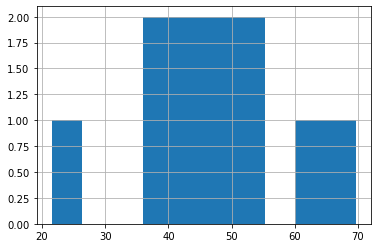

In [93]:
time_faith["faith_pd"].hist()

#### Looks slightly not linear, so I'll do spearman

<AxesSubplot:xlabel='Time difference', ylabel='faith_pd'>

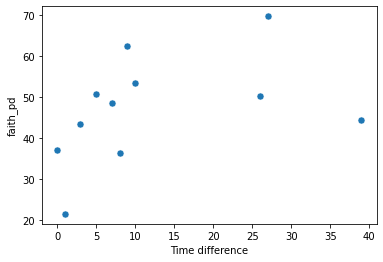

In [162]:
sns.scatterplot(y="faith_pd",
                x="Time difference",
                data=time_faith,
                s=50)

In [96]:
spearmanr(time_faith["faith_pd"],
          time_faith["Time difference"])

SpearmanrResult(correlation=0.5909090909090909, pvalue=0.05557560428877463)

## Psych boxplots

In [114]:
mapper = {"1 - Yes": "Breast Cancer", "2 - No": "Healthy Control"}

metadata["Chemotherapy"] = metadata["hcvsbc-cat"].apply(lambda x: mapper[x])

In [119]:
melted_demo = pd.melt(metadata[["age","cesd_total", "fact_c_total", "Chemotherapy"]],
                       id_vars="Chemotherapy")

In [130]:
melted_demo.head()

,Chemotherapy,variable,value
0,Breast Cancer,age,35.0
1,Healthy Control,age,24.0
2,Healthy Control,age,36.0
3,Healthy Control,age,19.0
4,Healthy Control,age,21.0


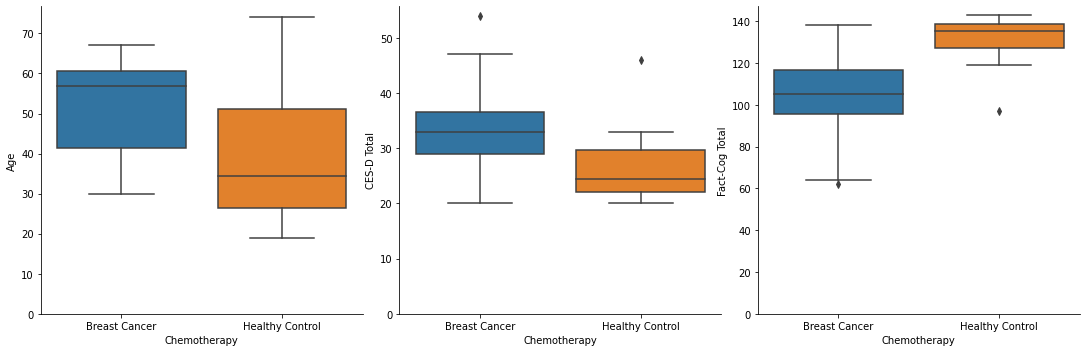

In [148]:
g = sns.catplot(x="Chemotherapy",
            y="value",
            data=melted_demo,
            col="variable",
            kind="box",
            sharey=False)

g.axes.flatten()[0].set_ylabel("Age")
g.axes.flatten()[1].set_ylabel("CES-D Total")
g.axes.flatten()[2].set_ylabel("Fact-Cog Total")

for ax in g.axes.flatten():
    ax.set_title("")
    ax.set_ylim(0,)

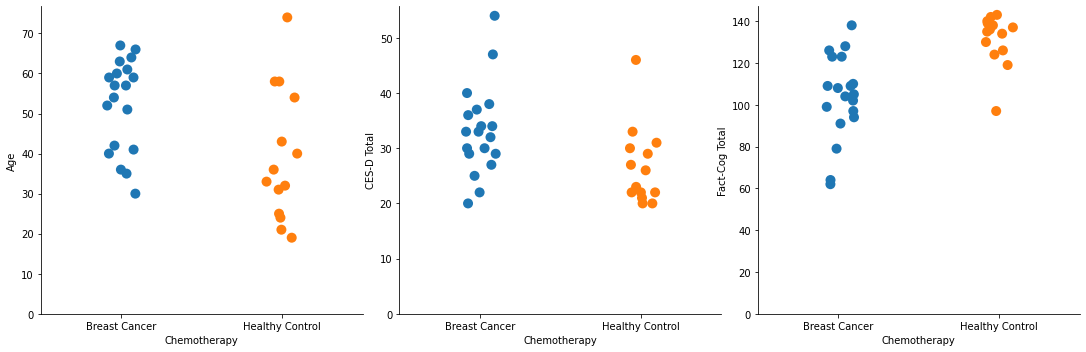

In [159]:
g = sns.catplot(x="Chemotherapy",
            y="value",
            data=melted_demo,
            col="variable",
            s=10,
            sharey=False)

g.axes.flatten()[0].set_ylabel("Age")
g.axes.flatten()[1].set_ylabel("CES-D Total")
g.axes.flatten()[2].set_ylabel("Fact-Cog Total")

for ax in g.axes.flatten():
    ax.set_title("")
    ax.set_ylim(0,)

## *Akkermansia* plots

In [200]:
tax_table = Artifact.load("tax-L6-table.qza").view(pd.DataFrame)

In [201]:
tax_mat = np.matrix(tax_table)
tax_mat /= np.sum(tax_mat, axis=1)
tax_table = pd.DataFrame(tax_mat, 
                         index=[int(ind) for ind in tax_table.index], 
                         columns=tax_table.columns)

In [202]:
akkermansia = [col for col in tax_table.columns if "Akkermansia" in col]

In [204]:
akkermansia_chemo = pd.concat([tax_table[akkermansia],
                               metadata["Chemotherapy"]],
                              axis=1).dropna()

Text(0, 0.5, 'Akkermansia relative abundance')

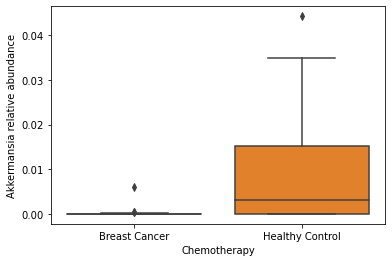

In [208]:
p = sns.boxplot(x="Chemotherapy",
                y=akkermansia[0],
                data=akkermansia_chemo)
p.set_ylabel("Akkermansia relative abundance")

In [210]:
akkermansia_time = pd.concat([tax_table[akkermansia],
                               metadata["Time difference"]],
                              axis=1).dropna()
akkermansia_time = akkermansia_time[akkermansia_time["Time difference"] >= 0]

Text(0, 0.5, 'Akkermansia relative abundance')

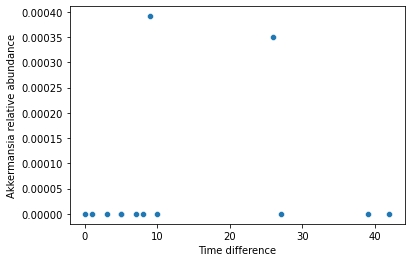

In [213]:
p = sns.scatterplot(x="Time difference",
                y=akkermansia[0],
                data=akkermansia_time)
p.set_ylabel("Akkermansia relative abundance")

In [214]:
spearmanr(akkermansia_time["Time difference"],
          akkermansia_time[akkermansia[0]])

SpearmanrResult(correlation=0.21869328378394914, pvalue=0.47286762074199706)

## Depression alpha diversity

In [220]:
chemo_cesd_faith = pd.concat([metadata[["cesd_total_categorical", "Chemotherapy"]],
                              faith_pd], 
                             axis=1).dropna()

<AxesSubplot:xlabel='Chemotherapy', ylabel='faith_pd'>

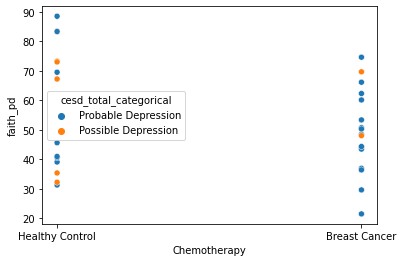

In [230]:
sns.scatterplot(y="faith_pd",
            x="Chemotherapy",
            hue="cesd_total_categorical",
            data=chemo_cesd_faith,
            x_jitter=10)

## PERMDISP

In [246]:
! qiime diversity core-metrics-phylogenetic \
--i-table table_noNA.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13100 \
--m-metadata-file Categorical-meta-noNA.tsv \
--output-dir core-diversity-results-noNA

Saved FeatureTable[Frequency] to: core-diversity-results-noNA/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results-noNA/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results-noNA/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results-noNA/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-diversity-results-noNA/evenness_vector.qza
Saved DistanceMatrix to: core-diversity-results-noNA/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results-noNA/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results-noNA/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-diversity-results-noNA/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-diversity-results-noNA/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-diversity-results-noNA/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-diversity-results-noNA/jac

In [247]:
! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results-noNA/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--p-method permdisp \
--o-visualization core-diversity-results-noNA/permdisp_hcvsbc_ununi.qzv

Saved Visualization to: core-diversity-results-noNA/permdisp_hcvsbc_ununi.qza.qzv


#### Unweighted Unifrac
#### F value	2.06044
#### p-value	0.158

In [251]:
! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results-noNA/weighted_unifrac_distance_matrix.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--m-metadata-column hcvsbc-cat \
--p-method permdisp \
--o-visualization core-diversity-results-noNA/permdisp_hcvsbc_wuni.qzv

Saved Visualization to: core-diversity-results-noNA/permdisp_hcvsbc_wuni.qzv


#### Weighted UniFrac
#### test statistic	1.22936
#### p-value	0.253